<a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/examples/Getting_Started_with_Auto_Arima_and_ETS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1qjiUfddfUolPl_QsFIwP8jN1NSGxnhtS)

# Introduction

Automatic forecasting tools tackle the needs for predictions over large collections of univariate time series that often arise in business practice and other contexts. Among these solutions, R's forecasting package `auto.arima` and `auto.ets` has been a reference for their accuracy and high quality for many years.

Unfortunately, baselines with their accuracy and computational efficiency were not available for Python yet. For this reason, we developed our new and highly efficient pure-Python implementation of these classic algorithms that we showcase in this notebook.

Table of Contents
1.   [Installing StatsForecast Library](#cell-1)
2.   [Load AirPassengers Example Data](#cell-2)
3.   [Fit AutoETS and AutoARIMA](#cell-3)
4.   [Plot and Evaluate Predictions](#cell-4)

If you are interested in further options you can take also se

5.   [Add Confidence Intervals to ARIMA](#cell-5)
6.   [Add External Regressors to ARIMA](#cell-6)
7.   [Include other Benchmark models](#cell-7)


If you are interested in talking about this or other time series models or want to sclae your models in production enviorments don't hesitate to send us an email at hello[at]nixtla.io or join our [slack community](https://join.slack.com/t/nixtlacommunity/shared_invite/zt-135dssye9-fWTzMpv2WBthq8NK0Yvu6A).

[Hyndman, RJ and Khandakar, Y (2008) "Automatic time series forecasting: The forecast package for R", Journal of Statistical Software, 26(3).](https://www.jstatsoft.org/article/view/v027i03)

<a name="cell-1"></a>
# 1. Installing StatsForecast Library

In [ ]:
%%capture
!pip install -U numba
!pip install -U statsmodels
!pip install statsforecast

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import auto_arima, ets
from statsforecast.utils import AirPassengers

In [ ]:
# If you want to list all avaiaible models run this lines
#from statsforecast.models import __all__
#__all__

<a name="cell-2"></a>
# 2. Loading AirPassengers Example Data

In [ ]:
# We define the train df. 
# We use the index functionality to make the training a lot faster.
Y_df = pd.DataFrame({'unique_id': np.ones(len(AirPassengers)),
                     'ds': pd.date_range(start='1949-01-01', 
                                         periods=len(AirPassengers), freq='M'),
                     'y': AirPassengers})
Y_df.tail(13)

,unique_id,ds,y
131,1.0,1959-12-31,405.0
132,1.0,1960-01-31,417.0
133,1.0,1960-02-29,391.0
134,1.0,1960-03-31,419.0
135,1.0,1960-04-30,461.0
136,1.0,1960-05-31,472.0
137,1.0,1960-06-30,535.0
138,1.0,1960-07-31,622.0
139,1.0,1960-08-31,606.0
140,1.0,1960-09-30,508.0


<a name="cell-3"></a>
# 3. Fit AutoArima and AutoETS

**AutoETS:** The exponential smoothing (ETS) algorithm is especially suited for data with seasonality and trend. ETS computes a weighted average over all observations in the input time series dataset as its prediction. In contrast to moving average methods with constant weights, ETS weights exponentially decrease over time, capturing long term dependencies while prioritizing new observations.

**AutoARIMA:** The autoregressive integrated moving average (ARIMA), combines differencing steps, lag regression and moving averages into a single method capable of modeling non-stationary time series. This method complements on ETS and it is based on the description of data's autocorrelations.

In [ ]:
Y_train_df = Y_df[Y_df.ds<='1959-12-31']
Y_test_df = Y_df[Y_df.ds>'1959-12-31']
print('len(Y_train_df)', len(Y_train_df))
print('len(Y_test_df)', len(Y_test_df))

len(Y_train_df) 132
len(Y_test_df) 12


In [ ]:
# Define the parameters that you want to use in your models. 
# Note: For all models the following parameters are passed automaticly and 
# don't need to be declared: (X, h, future_xreg).
# for ets we pass a ZMZ, model, which stands for error selected optimally,
season_length = 12
horizon = len(Y_test_df)
model = StatsForecast(Y_train_df.set_index('unique_id'), 
                      models=[(auto_arima, season_length),
                              (ets, season_length, 'ZMZ')],
                      freq='M', n_jobs=-1)

# In this step, you could include further models like: ses, adida, historic_average, 
# croston_classic, croston_sba, croston_optimized, seasonal_window_average, seasonal_naive, 
# imapa naive, random_walk_with_drift, window_average, seasonal_exponential_smoothing and tsb.

# For some models like ARIMA, include confidence intervals
# For the moment confidence intervals for ETS are unavailable
Y_hat_df = model.forecast(horizon).reset_index()
Y_hat_df.head()

,unique_id,ds,auto_arima_season_length-12,ets_season_length-12_model-ZMZ
0,1.0,1960-01-31,424.160156,419.163574
1,1.0,1960-02-29,407.081696,416.904449
2,1.0,1960-03-31,470.860535,480.243378
3,1.0,1960-04-30,460.913605,461.996887
4,1.0,1960-05-31,484.900879,463.853241


<a name="cell-4"></a>
# 4. Plot and Evaluate Predictions

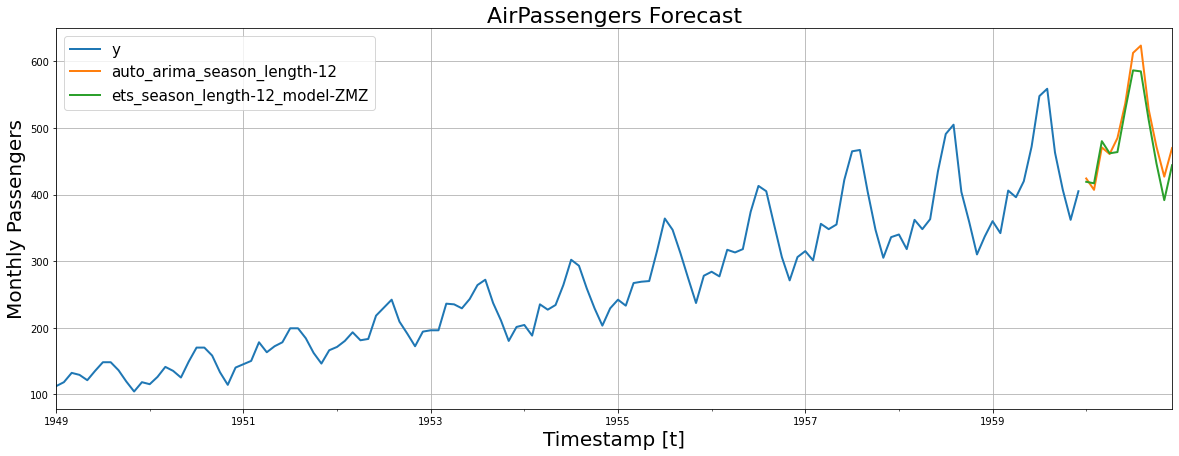

In [ ]:
#We are going to plot the models againts the real values of test.
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y',
         'auto_arima_season_length-12',
         'ets_season_length-12_model-ZMZ']].plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

Finally, we evaluate the predictions accuracy using the Mean Absolute Error:

$\qquad MAE = \frac{1}{Horizon} \sum_{\tau} |y_{\tau} - \hat{y}_{\tau}|\qquad$

In [ ]:
def mae(y_hat, y_true):
    return np.mean(np.abs(y_hat-y_true))

y_true = Y_test_df['y'].values
ets_preds = Y_hat_df['ets_season_length-12_model-ZMZ'].values
arima_preds = Y_hat_df['auto_arima_season_length-12'].values

print('ETS   MAE: %0.3f' % mae(ets_preds, y_true))
print('ARIMA MAE: %0.3f' % mae(arima_preds, y_true))

ETS   MAE: 16.222
ARIMA MAE: 18.551


<a name="cell-5"></a>
# Add Confidence Intervals to ARIMA (WIP)

<a name="cell-6"></a>
# Add external regressors to ARIMA (WIP)

<a name="cell-5"></a>
# Include other Benchmark models (WIP)